<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [169]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
# %watermark -p numpy,sklearn,pandas
# %watermark -p ipywidgets,cv2,PIL,matplotlib,plotly,netron
# %watermark -p torch,torchvision,torchaudio
# %watermark -p tensorflow,tensorboard,tflite
# %watermark -p onnx,tf2onnx,onnxruntime,tensorrt,tvm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False

# from IPython.display import display, Markdown, HTML, IFrame, Image, Javascript
# from IPython.core.magic import register_line_cell_magic, register_line_magic, register_cell_magic
# display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

import sys, os, io, logging, time, random, math
import json, base64, requests, shutil
import argparse, shlex, signal
import numpy as np

argparse.ArgumentParser.exit = lambda *arg, **kwargs: _IGNORE_

def _IMPORT(x):
    try:
        x = x.strip()
        if x[0] == '/' or x[0:2] == './':
            with open(x) as fr:
                x = fr.read()
        elif 'github' in x or 'gitee' in x:
            if x.startswith('import '):
                x = x[7:]
            if x.startswith('https://'):
                x = x[8:]
            if not x.endswith('.py'):
                x = x + '.py'
            x = x.replace('blob/main/', '').replace('blob/master/', '')
            if x.startswith('raw.githubusercontent.com'):
                x = 'https://' + x
                x = requests.get(x)
                if x.status_code == 200:
                    x = x.text
            elif x.startswith('github.com'):
                x = x.replace('github.com', 'raw.githubusercontent.com')
                mod = x.split('/')
                for s in ['main', 'master']:
                    x = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[-3:])
                    x = requests.get(x)
                    if x.status_code == 200:
                        x = x.text
                        break
            elif x.startswith('gitee.com'):
                mod = x.split('/')
                for s in ['/raw/main/', '/raw/master/']:
                    x = 'https://' + '/'.join(mod[:3]) + s + '/'.join(mod[3:])
                    x = requests.get(x)
                    if x.status_code == 200:
                        x = x.text
                        break
        exec(x, globals())
    except Exception as err:
        sys.stderr.write(f'request {x} : {err}')

def _DIR(x, dumps=True, ret=True):
    attrs = sorted([y for y in dir(x) if not y.startswith('_')])
    result = '%s: %s' % (str(type(x))[8:-2], json.dumps(attrs) if dumps else attrs)
    if ret:
        return result
    print(result)


In [ ]:
# !apt install -y texlive-full --fix-missing

In [8]:
import numpy as np
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from scipy import stats
import pandas as pd
from sklearn import preprocessing

from matplotlib.colors import LogNorm
import itertools 
# axes = list(itertools.chain.from_iterable(axes))
from sklearn.manifold import Isomap

from scipy.signal import medfilt
import scipy.signal as signal
from statsmodels.distributions.empirical_distribution import ECDF

import pickle

In [9]:
import math
import tensorflow_probability as tfp

In [3]:
plt.rcParams['font.sans-serif'] = 'SimHei'
# 负号正常显示
plt.rcParams['axes.unicode_minus'] = False
# 图像显示大小
plt.rcParams['figure.figsize'] = (6.0, 6.0)
# 使用数学公式 (depend: sudo apt install texlive-full)
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# 更多preamble, \newcommand自定义命令
# plt.rcParams['text.latex.preamble'] = [
#     r'\usepackage{amsmath}',
#     r'\usepackage{helvet}',
#     r'\usepackage{sansmath}',
#     r'\sansmath',
#     r'\renewcommand{\familydefault}{\sfdefault}',
#     r'\usepackage[T1]{fontenc}',
#     r'\usepackage{graphicx}',
#     r'\usepackage{relsize}',
#     r'\newcommand{\bigpi}{\scalebox{5}{\ensuremath{\pi}}}'
# ]

# 坐标label字体大小
plt.rcParams['axes.labelsize'] = 16

# 图像 插补方式: 紧邻
plt.rcParams['image.interpolation'] = 'nearest'
# color map
plt.rcParams['image.cmap'] = 'gray'

alpha是给定的（通常0.05或者0.01），是我用这个检验时给的一个严格程度，有个中文名叫置信水平。就像及格优良线一样，p<alpha了就拒绝原假设，p没小於alpha就说不足以拒绝原假设。
p-value的算法，是基於统计量在分布中的位置，给定的alpha实际也是给了检验统计量一个位置，即拒绝域。检验统计量在拒绝域的范围裏，就是拒绝原假设。p-value就是算出这个统计量所代表的在原假设为真的前提下的一个指标，根据小概率事件原则，这个指标不应该很小，所以p-value小到一定程度（也就是事先给的alpha），也就是p<alpha了，那就可以说原假设实在“太假了”，必须要拒绝了。（算法我觉得根据检验会不一样，真想了解的话可以找本书看一看最常见的检验的P值算法）

In [5]:
items = (
    'normal_100_0.01/Normalizer_100_0.01_0.7_0.8_0.9769989017513581.pkl', # 0
    'normal_100_0.05/Normalizer_100_0.05_0.7_0.8_0.9769989017513581.pkl',
    'normal_20_0.01/Normalizer_20_0.01_0.7_0.8_0.9066286282613873.pkl',   # 2
    'normal_20_0.05/Normalizer_20_0.05_0.7_0.8_0.9066286282613873.pkl',
    'normal_5_0.01/Normalizer_5_0.01_0.7_0.8_0.6323135569691658.pkl',   # 4
    'normal_5_0.05/Normalizer_5_0.05_0.7_0.8_0.6323135569691658.pkl',
    'normal_3_0.01/Normalizer_3_0.01_0.7_0.8_0.4924773871898651.pkl',   # 6
    'normal_3_0.05/Normalizer_3_0.05_0.7_0.8_0.4924773871898651.pkl',
)

In [10]:
efs = []
for item in items:
    with open(item, 'rb') as fr:
        ef = pickle.load(fr)
        efs.append(ef)
        
ecdf_data_out = []
for i in (3, 5, 20, 100):
    with open(f'data_out_{i}.pkl', 'rb') as fr:
        ecdf_data_out.append(pickle.load(fr))

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Normalizer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator PCA from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Normalizer from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


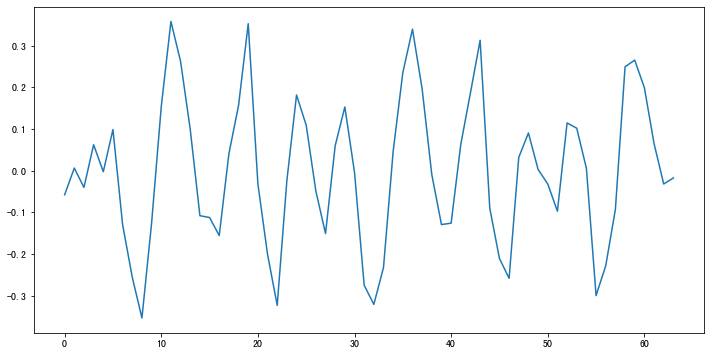

In [ ]:
fr

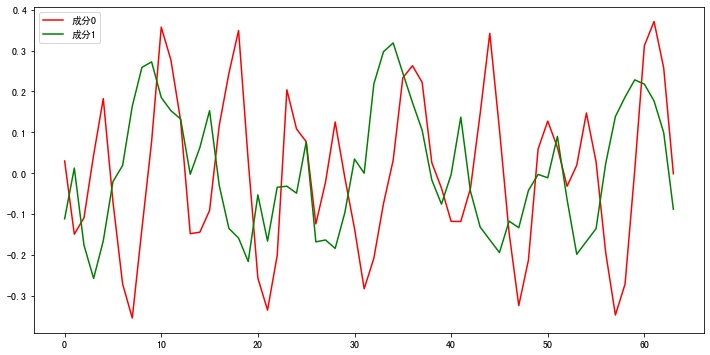

In [188]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
pca_out = pca.transform(scaler.transform(final_embs[5]))
axes.plot(pca_out[:, 0], label='成分0', color='r');
axes.plot(pca_out[:, 1], label='成分1', color='g');
axes.legend()
# axes.phase_spectrum(pca_out[:, 0]);
# axes.magnitude_spectrum(pca_out[:, 0]);
# axes.angle_spectrum(pca_out[:, 0]);
# axes.hist(pca_out[:, 1], bins=7);

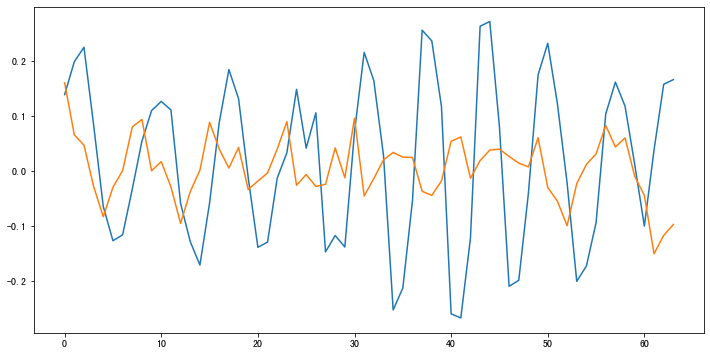

In [182]:
pca_out = pca.transform(scaler.transform(final_embs[9]))
fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
# axes.phase_spectrum(pca_out[:, 0]);
# axes.magnitude_spectrum(pca_out[:, 0]);
# axes.angle_spectrum(pca_out[:, 0]);
# axes.hist(pca_out[:, 0], bins=7,  density=True);
axes.plot(pca_out[:, 0:2]);

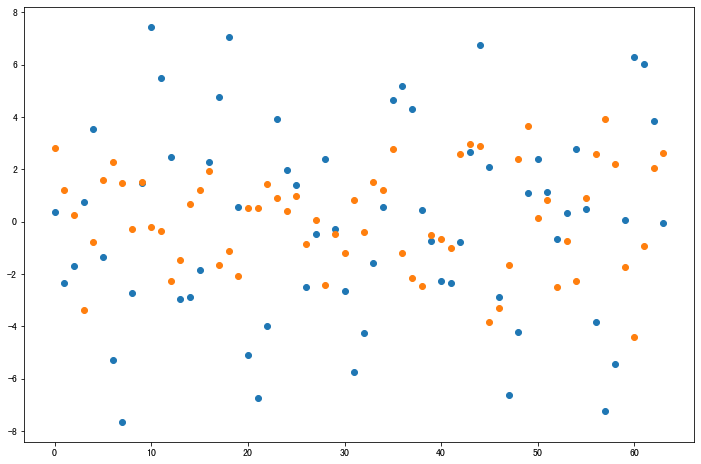

In [179]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True)
# pca_out1 = pca.transform(scaler.transform(final_embs[5]))
# pca_out2 = pca.transform(scaler.transform(final_embs[9]))
pca_out1 = pca.transform(final_embs[5])
pca_out2 = pca.transform(final_embs[8])
axes.scatter(range(64), pca_out1[:, 0])
axes.scatter(range(64), pca_out2[:, 0])

# N = 5 (5, 16) (8, 9)

In [75]:
final_embs = efs[4]['final_embs']
len(final_embs )

36

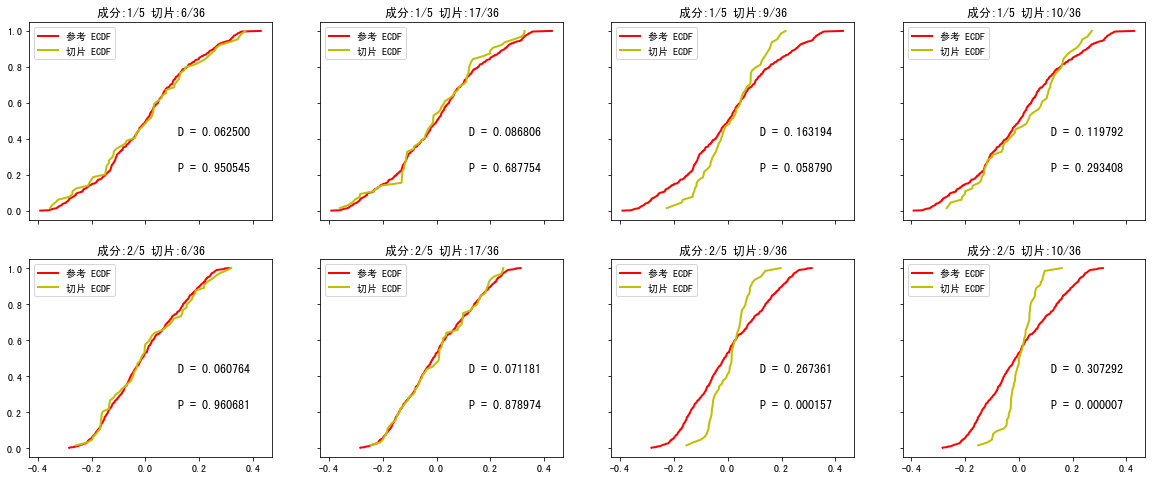

In [207]:
good_data_out = ecdf_data_out[1]
pca5_out = pca.transform(scaler.transform(final_embs[5]))
pca8_out = pca.transform(scaler.transform(final_embs[8]))

ecdf = [ECDF(sample) for sample in good_data_out.T] # len(ecdf): N

# sample 0.01
scaler = efs[4]['scaler'] #
pca = efs[4]['pca']
final_embs = efs[4]['final_embs']


samples = (5, 16, 8, 9)
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)
for i, feat in enumerate([0, 1]):
    for j, slic in enumerate(samples):
        out = pca.transform(scaler.transform(final_embs[slic])) # (x, N)
        cdf = ECDF(out.T[feat])
        D, P = stats.kstest(out.T[feat], cdf=lambda x: ecdf[feat](x))
        axes[i][j].set_title(f'成分:{feat + 1}/5 切片:{slic + 1}/36')
        axes[i][j].plot(ecdf[feat].x, ecdf[feat].y, color='r', lw=2, label='参考 ECDF')
        axes[i][j].plot(cdf.x, cdf.y, color='y', lw=2, label='切片 ECDF')
        axes[i][j].text(0.12, 0.42, 'D = %.6f' % D, fontsize=12)
        axes[i][j].text(0.12, 0.22, 'P = %.6f' % P, fontsize=12)
        axes[i][j].legend();

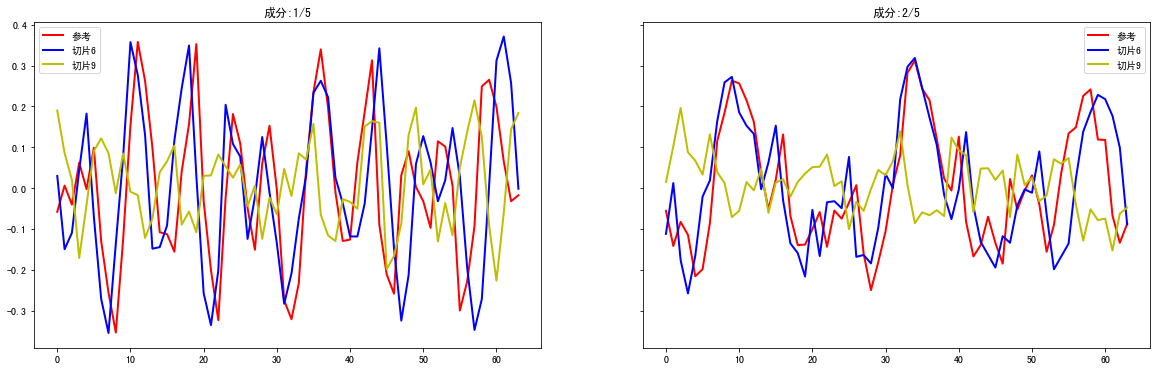

In [234]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True, sharey=True)
axes[0].plot(good_data_out[64:128, 0], label='参考', color='r', lw=2);
axes[0].plot(pca5_out[:, 0], label='切片6', color='b', lw=2);
axes[0].plot(pca8_out[:, 0], label='切片9', color='y', lw=2);
axes[0].set_title('成分:1/5')
axes[0].legend()
axes[1].plot(good_data_out[64:128, 1], label='参考', color='r', lw=2);
axes[1].plot(pca5_out[:, 1], label='切片6', color='b', lw=2);
axes[1].plot(pca8_out[:, 1], label='切片9', color='y', lw=2);
axes[1].set_title('成分:2/5')
axes[1].legend();
# plt.tight_layout();

-------------------